In [1]:
import os
import sys


os.environ["CUDA_VISIBLE_DEVICES"] = '3'
sys.path.append("sae_visualizer")


In [2]:
import sys
sys.path.append('/tmp/pycharm_project_349/ioi_subspaces')
sys.path.append('/tmp/pycharm_project_451')
from new_codebase import Circuit, Node
from load_sae import load_head_sae, is_available
import torch.utils.data


c = Circuit()

could not find model


In [11]:
import pandas as pd

def load_sweep_sae(node, names, perform_sanity_check=False):
    saes = pd.DataFrame(columns=['component', 'layer', 'head', 'id', 'seq_pos', 'node', 'sae']) 
    for name in names:
        sae = load_head_sae(node.layer, node.head, node.component_name, name, project_name='serimats', entity='georglange', version='v0', perform_sanity_check=perform_sanity_check)
        sae.requires_grad_(False)
        node = Node(layer=sae.cfg['layer'], head=sae.cfg['head'], component_name=sae.cfg['actv_name'][-1], seq_pos='end')
        row = {
            'sae': sae,
            'id': name,
            'node': node,
            'component': node.component_name,
            'layer': node.layer,
            'head': node.head,
            'seq_pos': node.seq_pos
        }
        saes.loc[len(saes)] = row
    return saes
node = Node(layer=9, head=6, component_name='z', seq_pos='end')
#sae_names = ['q-l9h6-0_5-2_8', 'skilled-sweep-158', 'gallant-sweep-176', 'summer-sweep-5', 'jumping-sweep-55', 'floral-sweep-26']
l9h6 = ['l5-8-80', 'l1-22-75', 'l1-11-54', 'l5-3-45', 'l1-3-30', 'l5-1-25']
l10h0 = ['l5-4-74', 'l1-10-71', 'l1-1_4-46', 'l5-0_7-41', 'l5-0_5-41', 'l1-0_9-40']  # l10h0
l9h9 = ['l5-9-89', 'l1-35-86', 'l5-3-73', 'l5-1_2-65', 'l1-4-63']
sae_names = l9h6 + l10h0 + l9h9
# l1   l1   l1    l0.5good     l0.5 similar      l1 128        l1 2048     
saes = load_sweep_sae(node, sae_names, perform_sanity_check=False)
saes

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


,component,layer,head,id,seq_pos,node,sae
0,z,9,6,l5-8-80,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
1,z,9,6,l1-22-75,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
2,z,9,6,l1-11-54,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
3,z,9,6,l5-3-45,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
4,z,9,6,l1-3-30,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
5,z,9,6,l5-1-25,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
6,z,10,0,l5-4-74,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()
7,z,10,0,l1-10-71,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()
8,z,10,0,l1-1_4-46,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()
9,z,10,0,l5-0_7-41,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()


In [25]:
def load_name_mover_sae(c):
    saes = pd.DataFrame(columns=['component', 'layer', 'head', 'id', 'seq_pos', 'node', 'sae']) 

    ioi_nodes = [c.heads[head].zs['end'] for head, head_data in c.heads.items() if head_data.head_class=='nm']

    for node in ioi_nodes:
        if is_available(node):
            print(node)
            component, layer, head = node.component_name, node.layer, node.head
            sae = load_head_sae(layer, head, component, perform_sanity_check=False)
            # turn off gradients
            sae.requires_grad_(False)
            row = {
                'sae': sae,
                'id': f'{component}-{layer}-{head}',
                'node': node,
                'component': component,
                'layer': layer,
                'head': head,
                'seq_pos': node.seq_pos
            }
            saes.loc[len(saes)] = row
    return saes

In [ ]:
import pandas as pd

def load_saes(c):
    saes = pd.DataFrame(columns=['component', 'layer', 'head', 'id', 'seq_pos', 'node', 'sae']) 
    for node in c.nodes:
        if is_available(node, project_name='sae-all-ioi-heads'):
            print(node)
            component, layer, head = node.component_name, node.layer, node.head
            version = 'v25'
            if (component, layer, head) in [('z', 9, 6), ('z', 10, 0), ('z', 9, 9)]:
                version = 'v7'
            sae = load_head_sae(layer, head, component, perform_sanity_check=False, project_name='sae-all-ioi-heads', version=version)
            if sae.cfg['d_hidden'] != 1000:
                sae.requires_grad_(False)
                row = {
                    'sae': sae,
                    'name': f'{component}-{layer}-{head}',
                    'id': node,
                    'component': component,
                    'layer': layer,
                    'head': head,
                    'seq_pos': node.seq_pos,
                    'node': node
                }
                saes.loc[len(saes)] = row
    return saes
saes = load_saes(c)
clear_output()
saes

In [4]:
import pandas as pd

encoder = load_head_sae(9, 9, 'z', perform_sanity_check=True)
saes = pd.DataFrame.from_dict({
    'component': ['z'],
    'layer': [9],
    'head': [9],
    'id': ['z-l9h9'],
    'seq_pos': ['end'],
    'node': [Node(layer=9, head=9, component_name='z', seq_pos='end')],
    'sae': [encoder]
})
saes

           INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                            cuda.py:58

/var/local/glang/anaconda3/envs/serimats/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_l0_loss          │      0.18046875298023224      │
│            test_l1            │     0.0004202829150017351     │
│           test_loss           │     0.014962943270802498      │
│           test_mse            │     0.014542659744620323      │
│ test_reconstruction_loss_mean │       0.338573157787323       │
│ test_reconstruction_loss_zero │      0.2697955369949341       │
└───────────────────────────────┴───────────────────────────────┘

,component,layer,head,id,seq_pos,node,sae
0,z,9,9,z-l9h9,end,"Node(component_name=z, layer=9, head=9, seq_po...",SparseAutoencoder()


In [5]:
from transformer_lens import HookedTransformer


model = HookedTransformer.from_pretrained('gpt2-small', device='cuda')
model.requires_grad_(False)
print('')

Loaded pretrained model gpt2-small into HookedTransformer



# Load IOI dataset

In [6]:
from ioi_utils import PromptDataset, PromptDistribution, NAMES, PLACES, OBJECTS, PREFIXES, TEMPLATES


def sample_ioi(model, prompt_distribution, patterns, samples_per_combination: int):
    prompts = []
    for pattern in patterns:
        for _ in range(samples_per_combination):
            prompts.append(prompt_distribution.sample_one(pattern, model))
    dataset = PromptDataset(prompts, model)
    return dataset


ioi_distribution = PromptDistribution(
    prefix_len=2,
    templates=TEMPLATES[:2],
    names=NAMES,
    places=PLACES,
    objects=OBJECTS,
    prefixes=PREFIXES
)

ioi_dataset = sample_ioi(model, ioi_distribution, ['ABB', 'BAB'], 10000)
batch_sampler = torch.utils.data.BatchSampler(
    torch.utils.data.SequentialSampler(ioi_dataset),
    batch_size=10,
    drop_last=False,
)
ioi_loader = torch.utils.data.DataLoader(
    ioi_dataset,
    sampler=batch_sampler,
    batch_size=None,
)

# for test set, we need the same names etc, just different combinations
ioi_test_dataset = sample_ioi(model, ioi_distribution, ['ABB', 'BAB'], 10000)
batch_sampler = torch.utils.data.BatchSampler(
    torch.utils.data.SequentialSampler(ioi_test_dataset),
    batch_size=10,
    drop_last=False,
)
ioi_test_loader = torch.utils.data.DataLoader(
    ioi_test_dataset,
    sampler=batch_sampler,
    batch_size=None,
)

# Calculate alive and ioi features

In [7]:
from autoscoring import get_alive_neurons
from IPython.display import clear_output
from functools import partial


def alive_neurons(row):
    row['sae'].cuda()
    idx_alive = get_alive_neurons(row['sae'], model)
    row['n_alive'] = idx_alive.numel()
    row['features_alive'] = idx_alive.cpu()
    return row
saes = saes.apply(alive_neurons, axis=1)
clear_output()
saes

,component,layer,head,id,seq_pos,node,sae,n_alive,features_alive
0,z,9,9,z-l9h9,end,"Node(component_name=z, layer=9, head=9, seq_po...",SparseAutoencoder(),724,"[tensor(0), tensor(1), tensor(2), tensor(3), t..."


In [12]:
saes.to_csv('sae_alive_neurons.csv')

In [ ]:
# save features_alive
import pickle

with open('../data/features_alive.pkl', 'wb') as f:
    pickle.dump(features_alive, f)

In [10]:
# load features_alive
import pickle

with open('../data/features_alive.pkl', 'rb') as f:
    features_alive = pickle.load(f)

In [8]:
from autoscoring import get_ioi_neurons
def ioi_neurons(row):
    encoder = row['sae']
    node = row['node']
    idx_alive = get_ioi_neurons(encoder, model, ioi_loader, node, max_batches=1000)
    row['n_ioi'] = idx_alive.numel()
    row['idx_ioi_neurons'] = idx_alive.cpu()
    return row
saes = saes.apply(ioi_neurons, axis=1)
clear_output()
saes

,component,layer,head,id,seq_pos,node,sae,n_alive,features_alive,n_ioi,idx_ioi_neurons
0,z,9,9,z-l9h9,end,"Node(component_name=z, layer=9, head=9, seq_po...",SparseAutoencoder(),724,"[tensor(0), tensor(1), tensor(2), tensor(3), t...",622,"[tensor(0), tensor(1), tensor(2), tensor(3), t..."


In [15]:
# to pickle
import pickle
# save saes
with open('../data/saes.pkl', 'wb') as f:
    pickle.dump(saes, f)

In [ ]:
import pickle

with open('../data/ioi_neurons_idx.pkl', 'wb') as f:
    pickle.dump(ioi_neurons_idx, f)

In [11]:
import pickle

with open('../data/ioi_neurons_idx.pkl', 'rb') as f:
    ioi_neurons_idx = pickle.load(f)

# Extract feature activations and count them

In [9]:
import torch
from tqdm import tqdm
from research.autoscoring import run_with_cache, LabeledTensor


measures = ['count', 'sum', 'total', ]
patterns = ['ABB', 'BAB']
roles = ['s', 'io']


@torch.no_grad()
def get_actv_counts(model, ioi_loader, saes, measures=measures, patterns=patterns, roles=roles):
    num_neurons = max([sae.cfg['d_hidden'] for sae in saes.sae])
    shape = (len(measures), len(saes), len(patterns), len(roles), len(NAMES), num_neurons)
    actv_counts = LabeledTensor(shape, measures=measures, ioi_nodes=saes.id, patterns=patterns, 
                            roles=roles, names=NAMES, device='cpu')
    for batch in tqdm(ioi_loader):
        cache = run_with_cache(model, batch, saes.node.to_list())
        for i, row in saes.iterrows():
            actvs = cache[i]  # (batch, neurons)
            feature_actvs = row.sae.encoder(actvs)
            is_active = feature_actvs > 0
            for j, prompt in enumerate(batch.prompts):
                p = prompt.pattern
                s = prompt.s_name
                io = prompt.io_name
                
                # Count
                name = row.id
                actv_counts['count', name, p, 's', s] += is_active[j].int().cpu()
                actv_counts['count', name, p, 'io', io] += is_active[j].int().cpu()
                
                # Sum
                actv_counts['sum', name, p, 's', s] += feature_actvs[j].cpu()
                actv_counts['sum', name, p, 'io', io] += feature_actvs[j].cpu()
                
                # Total
                actv_counts['total', name, p, 's', s] += 1
                actv_counts['total', name, p, 'io', io] += 1

    return actv_counts

In [10]:
actv_counts = get_actv_counts(model, ioi_loader, saes)
test_actv_counts = get_actv_counts(model, ioi_test_loader, saes)

#actv_counts.save('../data/feature_actvs.pt')
#test_actv_counts.save('../data/test_feature_actvs.pt')

100%|██████████| 2000/2000 [01:50<00:00, 18.06it/s]


In [13]:
actv_counts = LabeledTensor.load('../data/feature_actvs.pt')
test_actv_counts = LabeledTensor.load('../data/test_feature_actvs.pt')

# Feature Scoring based on activation counts
      

In [11]:
from research.autoscoring import get_genders


is_male = get_genders(NAMES)

In [12]:
from functools import partial
import pandas as pd
from tqdm.auto import tqdm

from research.autoscoring import io_name_score, s_name_score, contains_name_score, first_name_score, second_name_score, name_x_pos, gender_x_role_score, name_score, io_pos_score, gender_score, context_position_score, name_x_context_pos_score


tqdm.pandas()


# these feature types are only well-defined over s2 and end nodes
# you can't calculate them on io or s1 nodes because their sequence position isn't fixed which is an assumption that these functions make
name_feature_types = {
    'io_name': io_name_score,
    's_name': s_name_score,
    'contains_name': contains_name_score,
    'first_name': first_name_score,
    'second_name': second_name_score,
    'first_name_S': partial(name_x_pos, pattern='BAB', role='s'),
    'second_name_IO': partial(name_x_pos, pattern='BAB', role='io'),
    'first_name_IO': partial(name_x_pos, pattern='ABB', role='io'),
    'second_name_S': partial(name_x_pos, pattern='ABB', role='s'),
    's_is_male': partial(gender_x_role_score, role='s', gender='M', is_male=is_male),
    's_is_female': partial(gender_x_role_score, role='s', gender='F', is_male=is_male),
    'io_is_male': partial(gender_x_role_score, role='io', gender='M', is_male=is_male),
    'io_is_female': partial(gender_x_role_score, role='io', gender='F', is_male=is_male),

}

def describe_features(df, only_io=False):  # set only_io=True to calculate features on the IO/s1 positions only using the IO node
    feature_descriptions = []
    id = df.id.iloc[0]
    print(id)
        
    for feature_id in range(df.sae.iloc[0].cfg['d_hidden']):
        for _, row in df[df.seq_pos.isin(['s2', 'end'])].iterrows():
            node = row['node']

            # DEAD NEURONS
            if feature_id not in row['features_alive']:
                frow = {'node': node, 'feature_id': feature_id, 'feature_type': 'dead', 'topk': 0, 'names': '', 
                    'recall': 0, 'precision': 0, 'f_score': 0, 'component': id}
                feature_descriptions.append(frow)

            # NEURONS THAT NEVER FIRE ON IOI PROMPTS
            elif feature_id not in row['idx_ioi_neurons']:
                frow = {'node': node, 'feature_id': feature_id, 'feature_type': 'not_ioi', 'topk': 0, 'names': '',
                    'recall': 0, 'precision': 0, 'f_score': 0, 'component': id}
                feature_descriptions.append(frow)
            else:
                # FEATURES ON S2 AND END NODES
                for feature_type, func in name_feature_types.items():
                    scores = func(actv_counts[:, id, :, :, :, feature_id], test_actv_counts=test_actv_counts[:, id, :, :, :, feature_id])
                    scores['node'] = node
                    scores['feature_id'] = feature_id
                    scores['feature_type'] = feature_type
                    scores['component'] = id
                    feature_descriptions.append(scores)

                for pattern in patterns:
                    # select the number of activations at the io position
                    score = io_pos_score(actv_counts[:, id, :, :, :, feature_id], pattern, test_actv_counts=test_actv_counts[:, id, :, :, :, feature_id])
                    score['node'] = node
                    score['feature_id'] = feature_id
                    score['component'] = id
                    feature_descriptions.append(score)

                for role in roles:
                    for gender in ['M', 'F']:
                        score = gender_x_role_score(actv_counts[:, id, :, :, :, feature_id], role, gender, is_male=is_male, test_actv_counts=test_actv_counts[:, id, :, :, :, feature_id])
                        score['node'] = node
                        score['feature_id'] = feature_id
                        score['component'] = id
                        feature_descriptions.append(score)

        # FEATURES ON IO AND S1 NODES
        if df.seq_pos.str.contains('io').any():
            io_node = df.loc[df.seq_pos == 'io', 'node'].iloc[0]
            s_node = None if only_io else df.loc[df.seq_pos == 's1', 'node'].iloc[0]
            score = name_score(actv_counts[:, :, :, :, :, feature_id], io_node, s1_node=s_node, test_actv_counts=test_actv_counts[:, :, :, :, :, feature_id])
            score['node'] = io_node
            score['feature_id'] = feature_id
            score['feature_type'] = 'current_name'
            score['component'] = id
            feature_descriptions.append(score)

            for gender in ['M', 'F']:
                score = gender_score(actv_counts[:, :, :, :, :, feature_id], io_node, gender, is_male, s1_node=s_node, test_actv_counts=test_actv_counts[:, :, :, :, :, feature_id])
                score['node'] = io_node
                score['feature_id'] = feature_id
                score['component'] = id
                feature_descriptions.append(score)

            for position in [1, 2]:
                score = context_position_score(actv_counts[:, :, :, :, :, feature_id], io_node, position, s1_node=s_node, test_actv_counts=test_actv_counts[:, :, :, :, :, feature_id])
                score['node'] = io_node
                score['feature_id'] = feature_id
                score['component'] = id
                feature_descriptions.append(score)

                score = name_x_context_pos_score(actv_counts[:, :, :, :, :, feature_id], io_node, position, s1_node=s_node, test_actv_counts=test_actv_counts[:, :, :, :, :, feature_id])
                score['node'] = io_node
                score['feature_id'] = feature_id
                score['feature_type'] = f'current_name_pos_{position}'
                score['component'] = id
                feature_descriptions.append(score)
    df = pd.DataFrame(feature_descriptions)
    return df


In [13]:
# without parallelization
df = saes.groupby('id').progress_apply(describe_features, only_io=True)

  0%|          | 0/1 [00:00<?, ?it/s]

z-l9h9


In [15]:
for i, row in saes.iterrows():
    print(row.id, row.idx_ioi_neurons.shape, row.n_alive)

l5-8-80 torch.Size([366]) 1017
l1-22-75 torch.Size([812]) 1149
l1-11-54 torch.Size([810]) 1249
l5-3-45 torch.Size([516]) 1136
l1-3-30 torch.Size([878]) 1278
l5-1-25 torch.Size([574]) 1163
l5-4-74 torch.Size([1945]) 1331
l1-10-71 torch.Size([1810]) 1526
l1-1_4-46 torch.Size([1796]) 1363
l5-0_7-41 torch.Size([1859]) 891
l5-0_5-41 torch.Size([1819]) 770
l1-0_9-40 torch.Size([1817]) 1214
l5-9-89 torch.Size([2001]) 1152
l1-35-86 torch.Size([1833]) 1216
l5-3-73 torch.Size([1962]) 1263
l5-1_2-65 torch.Size([1937]) 1423
l1-4-63 torch.Size([1771]) 1224


In [17]:
# for each SAE neuron, accept the feature with the best training f_score
final_df = df.groupby(['component', 'feature_id']).apply(lambda df: df.loc[df.f_score.idxmax()])
final_df.to_csv('../data/feature_descriptions_nm_z_l9h9.csv')
final_df[final_df.f_score > 0.85].head(30)

topk                                              names  \
component feature_id                                                            
z-l9h9    3             23  [Ethan, Evan, Elizabeth, Alexis, Andrew, Jerem...   
          9              1                                        [Sebastian]   
          36            23  [Ty, Tim, Tyler, Thomas, Kent, Ray, Ted, Taylo...   
          40             5           [Andrew, Nicholas, Olivia, Colin, Molly]   
          41             1                                           [Ashley]   
          55             1                                             [Alex]   
          70             1                                            [Ethan]   
          77             1                                          [Jessica]   
          96            30  [Mark, Samuel, Maria, Maya, Thomas, Deb, Mason...   
          123            5         [Adrian, Julian, Damian, Brian, Nathaniel]   
          127            8   [Hudson, Susan, Ted, Evan, Jen, Ken, Jeff, Eric]   
          164           30  [Jordan, Jacob, Jackson, Jennifer, James, Dami...   
          180            8  [Jackson, Andrew, Cole, Jacob, Jordan, Joseph,...   
          184           21  [Ty, Damian, Robert, Ray, Rachel, Ross, Riley,...   
          186            7  [Damian, Rachel, Sam, Audrey, Sebastian, Saman...   
          209           17  [Hudson, Ethan, Haley, Hannah, Henry, Andrew, ...   
          224           15  [Damian, Christopher, Steven, Robert, Jen, Ste...   
          232           11  [Gabriel, Greg, Grant, Savannah, Grace, Elias,...   
          248           13  [Olivia, Leo, Joe, Frank, Rob, Ian, Brooke, Zo...   
          272            5               [Brooke, Rachel, Ray, Piper, Carter]   
          296           17  [Levi, Benjamin, Jeremiah, Aaron, Jacob, Danie...   
          298            7  [Owen, William, Wyatt, Dave, Steve, Will, Thomas]   
          306            1                                             [Jake]   
          308           24  [Damian, Tim, Sam, Amy, Liam, Taylor, Angel, A...   
          310           24  [Nora, Nolan, Nicholas, Quinn, Jennifer, Owen,...   
          311            3                             [Gabriel, Grant, Jeff]   
          348            1                                          [Patrick]   
          353            8  [Jordan, Dan, Daniel, Gabriel, Adrian, Ted, Me...   
          361           23  [Ethan, Maya, Andrea, Owen, Kent, Hannah, Jenn...   
          415            4                        [Maya, Will, Harper, Kevin]   

                        recall  precision   f_score  recall_test  \
component feature_id                                               
z-l9h9    3           0.830579   0.873070  0.851294     0.837863   
          9           0.772152   0.983871  0.865248     0.811111   
          36          0.882824   0.874185  0.878483     0.859674   
          40          0.776371   0.981333  0.866902     0.764579   
          41          0.978723   0.884615  0.929293     0.989899   
          55          0.843137   0.877551  0.860000     0.782178   
          70          0.831776   1.000000  0.908163     0.793478   
          77          0.868421   0.835443  0.851613     0.841463   
          96          0.861583   0.855400  0.858480     0.872701   
          123         0.905738   0.926625  0.916062     0.935950   
          127         0.883812   0.864623  0.874112     0.833113   
          164         0.897902   0.945856  0.921256     0.904554   
          180         0.864652   0.866930  0.865789     0.870466   
          184         0.859423   0.862087  0.860753     0.851590   
          186         0.820988   0.891122  0.854618     0.860643   
          209         0.851539   0.862469  0.856969     0.853768   
          224         0.770504   0.966606  0.857486     0.789328   
          232         0.796764   0.922717  0.855128     0.818182   
          248         0.835069   0.901593  0.867057     0.830729   
 

In [38]:
final_df.reset_index(drop=True).groupby(['component', 'feature_type']).node.count().unstack('feature_type')

feature_type,contains_name,dead,first_name,first_name_IO,first_name_S,io_is_female,io_is_male,io_name,io_position_ABB,io_position_BAB,not_ioi,s_is_male,s_name,second_name_IO,second_name_S
component,,,,,,,,,,,,,,,
l1-0_9-40,28.0,834.0,3.0,246.0,21.0,NaN,NaN,712.0,NaN,NaN,77.0,NaN,1.0,118.0,8.0
l1-10-71,176.0,522.0,5.0,199.0,22.0,1.0,NaN,932.0,NaN,NaN,96.0,NaN,NaN,91.0,4.0
l1-11-54,241.0,799.0,NaN,112.0,NaN,NaN,13.0,378.0,7.0,8.0,463.0,4.0,NaN,18.0,5.0
l1-1_4-46,35.0,685.0,3.0,272.0,24.0,NaN,NaN,815.0,NaN,NaN,98.0,NaN,NaN,103.0,13.0
l1-22-75,335.0,899.0,NaN,85.0,2.0,NaN,23.0,281.0,9.0,11.0,370.0,9.0,NaN,18.0,6.0
l1-3-30,76.0,770.0,NaN,156.0,1.0,NaN,3.0,568.0,6.0,1.0,426.0,3.0,NaN,34.0,4.0
l1-35-86,409.0,832.0,NaN,45.0,18.0,4.0,35.0,540.0,3.0,9.0,76.0,10.0,NaN,65.0,2.0
l1-4-63,67.0,824.0,NaN,59.0,20.0,NaN,2.0,884.0,NaN,NaN,89.0,NaN,NaN,101.0,2.0
l5-0_5-41,6.0,1278.0,2.0,70.0,4.0,NaN,NaN,594.0,NaN,NaN,57.0,NaN,NaN,33.0,4.0


In [2]:
import pandas as pd

final_df = pd.read_csv('../data/feature_descriptions_nm_sweep.csv')

In [15]:
# Summary
for node in ioi_nodes:
    print(node)
    for feature_type in final_df.feature_type.unique():
        print(feature_type, len(final_df[(final_df.feature_type == feature_type) & (final_df.f_score > 0.4) & (final_df.node == node)]))
    print()

NameError: name 'ioi_nodes' is not defined

# Random Plots

In [3]:
melt = pd.melt(final_df.reset_index(drop=True), id_vars=['node', 'feature_id', 'feature_type', 'topk', 'component', 'names'], 
        value_vars=['recall', 'precision', 'f_score'],
        value_name='value', var_name='metric')


In [4]:
melt


,node,feature_id,feature_type,topk,component,names,metric,value
0,"Node(component_name=z, layer=10, head=0, seq_p...",0,not_ioi,0,l1-0_9-40,NaN,recall,0.000000
1,"Node(component_name=z, layer=10, head=0, seq_p...",1,io_name,1,l1-0_9-40,['Sebastian'],recall,0.000000
2,"Node(component_name=z, layer=10, head=0, seq_p...",2,io_name,1,l1-0_9-40,['Sebastian'],recall,0.000000
3,"Node(component_name=z, layer=10, head=0, seq_p...",3,dead,0,l1-0_9-40,NaN,recall,0.000000
4,"Node(component_name=z, layer=10, head=0, seq_p...",4,io_name,1,l1-0_9-40,['Sebastian'],recall,0.000000
...,...,...,...,...,...,...,...,...
104443,"Node(component_name=z, layer=9, head=9, seq_po...",2043,first_name_S,1,l5-9-89,['Chelsea'],f_score,0.044444
104444,"Node(component_name=z, layer=9, head=9, seq_po...",2044,io_name,1,l5-9-89,['Sebastian'],f_score,0.000000
104445,"Node(component_name=z, layer=9, head=9, seq_po...",2045,dead,0,l5-9-89,NaN,f_score,0.000000
104446,"Node(component_name=z, layer=9, head=9, seq_po...",2046,dead,0,l5-9-89,NaN,f_score,0.000000


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fa1855ea440>
Traceback (most recent call last):
  File "/var/local/glang/anaconda3/envs/serimats/lib/python3.10/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


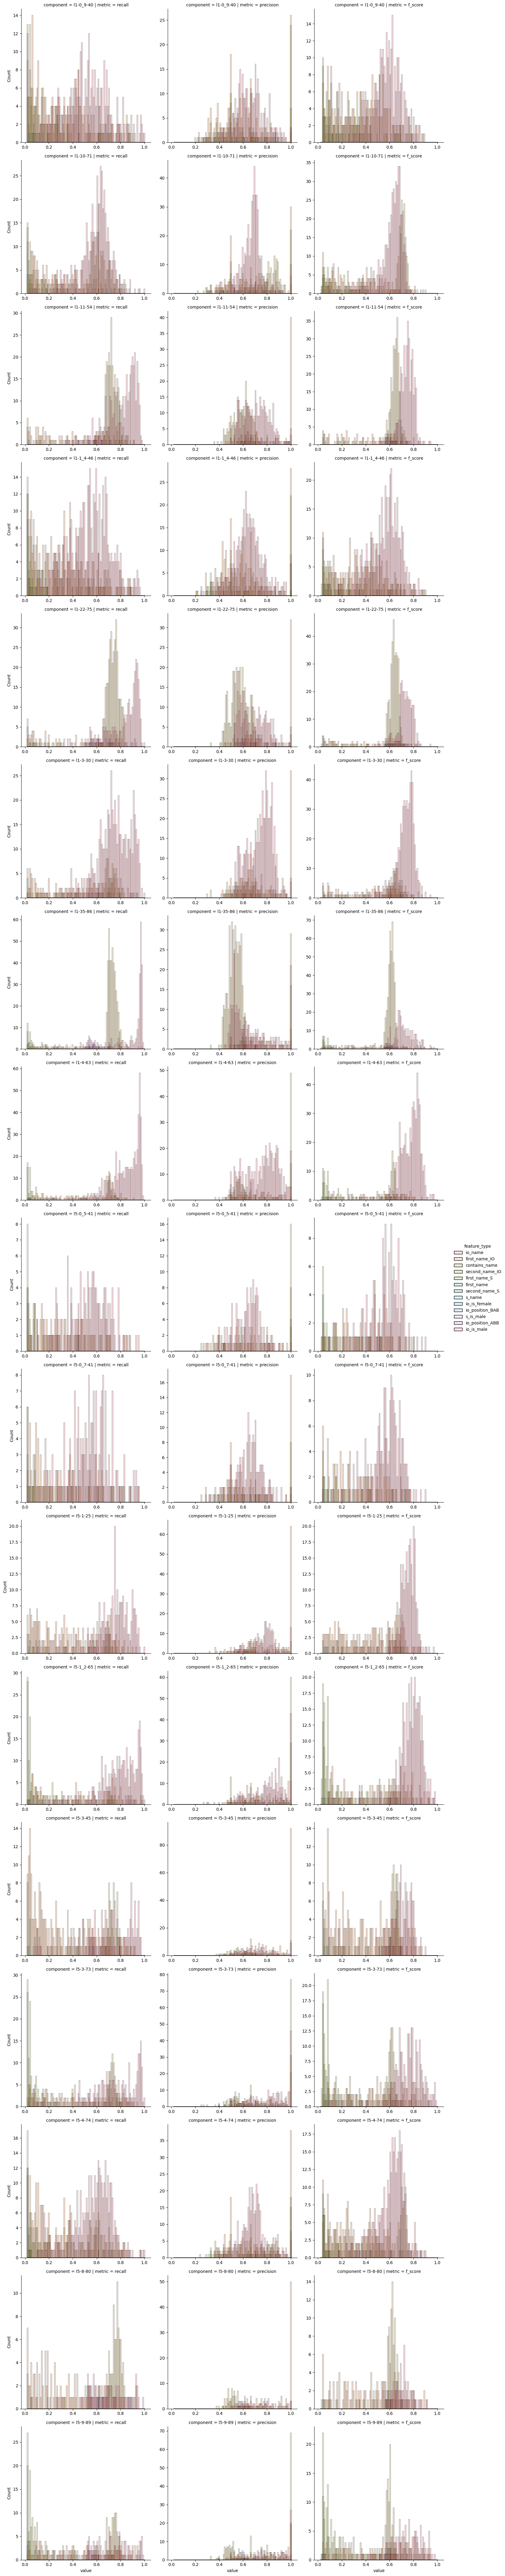

In [5]:
import seaborn as sns

sns.displot(data=melt[melt['value'] > 0.], x='value', col='metric', hue='feature_type', bins=100, 
            alpha=0.2, kind='hist', row='component', legend=True, facet_kws={'sharex': False, 'sharey': False})


In [12]:
saes

,component,layer,head,id,seq_pos,node,sae
0,z,9,6,l5-8-80,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
1,z,9,6,l1-22-75,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
2,z,9,6,l1-11-54,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
3,z,9,6,l5-3-45,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
4,z,9,6,l1-3-30,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
5,z,9,6,l5-1-25,end,"Node(component_name=z, layer=9, head=6, seq_po...",SparseAutoencoder()
6,z,10,0,l5-4-74,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()
7,z,10,0,l1-10-71,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()
8,z,10,0,l1-1_4-46,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()
9,z,10,0,l5-0_7-41,end,"Node(component_name=z, layer=10, head=0, seq_p...",SparseAutoencoder()


In [ ]:
l9h6 = ['l5-8-80', 'l1-22-75', 'l1-11-54', 'l5-3-45', 'l1-3-30', 'l5-1-25']
l10h0 = ['l5-4-74', 'l1-10-71', 'l1-1_4-46', 'l5-0_7-41', 'l5-0_5-41', 'l1-0_9-40']  # l10h0
l9h9 = ['l5-9-89', 'l1-35-86', 'l5-3-73', 'l5-1_2-65', 'l1-4-63']

In [13]:
final_df['l0'] = 'unk'
final_df.loc[final_df.component.isin(['l1-3-30', 'l1-0_9-40', 'l1-4-63']), 'l0'] = 'low'
final_df.loc[final_df.component.isin(['l1-11-54', 'l1-1_4-46', ]), 'l0'] = 'medium'
final_df.loc[final_df.component.isin(['l1-22-75', 'l1-10-71', 'l1-35-86']), 'l0'] = 'high'


Text(0.5, 1.0, 'IO name features')

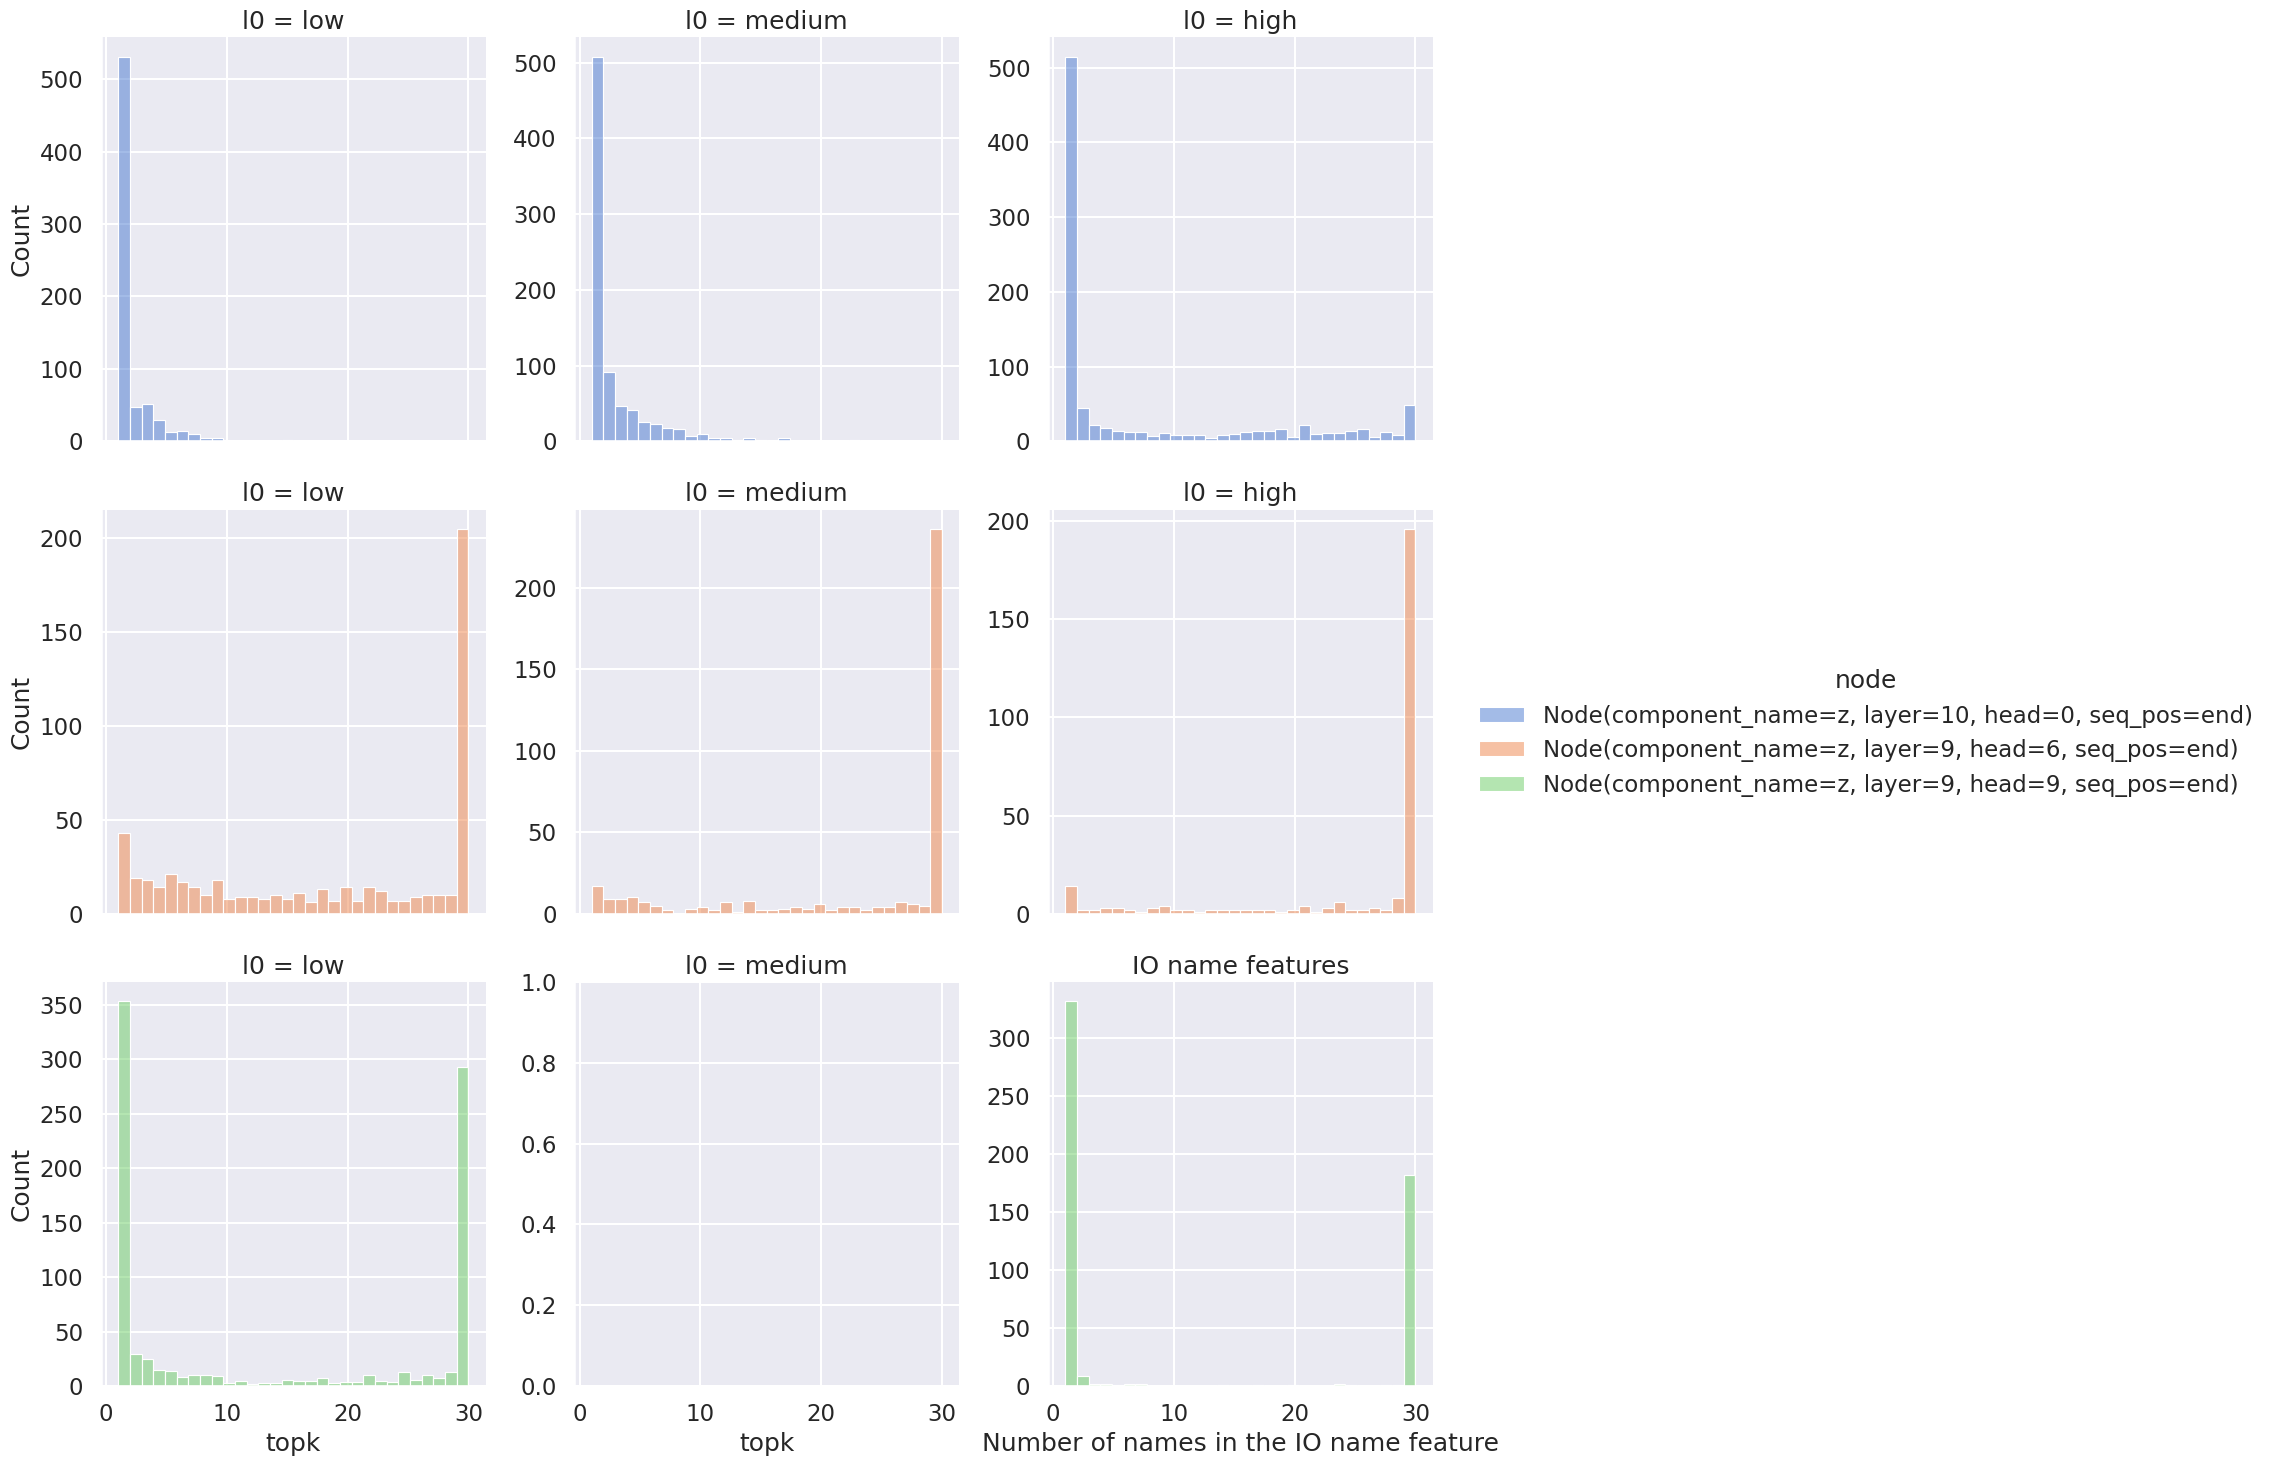

In [25]:
g = sns.displot(final_df[final_df.feature_type == 'io_name'], x='topk', hue='node', bins=30, kind='hist', col='l0', row='node', facet_kws={'sharex': True, 'sharey': False}, col_order=['low', 'medium', 'high'])

# Here's the adjustment for the subplot titles
for ax in g.axes.flat:
    # Extract the 'l0' value from the original title
    # Original title format is expected to be "node = [node_value] | l0 = [l0_value]"
    # This will split the title on '|', strip extra whitespace, and keep only the part after 'l0 ='
    l0_value = ax.get_title().split('|')[-1].strip()
    # Set the new title with only the 'l0' value, adjusting the rotation as needed
    ax.set_title(l0_value, rotation=0)
import matplotlib.pyplot as plt
plt.xlabel('Number of names in the IO name feature')
plt.title('IO name features')

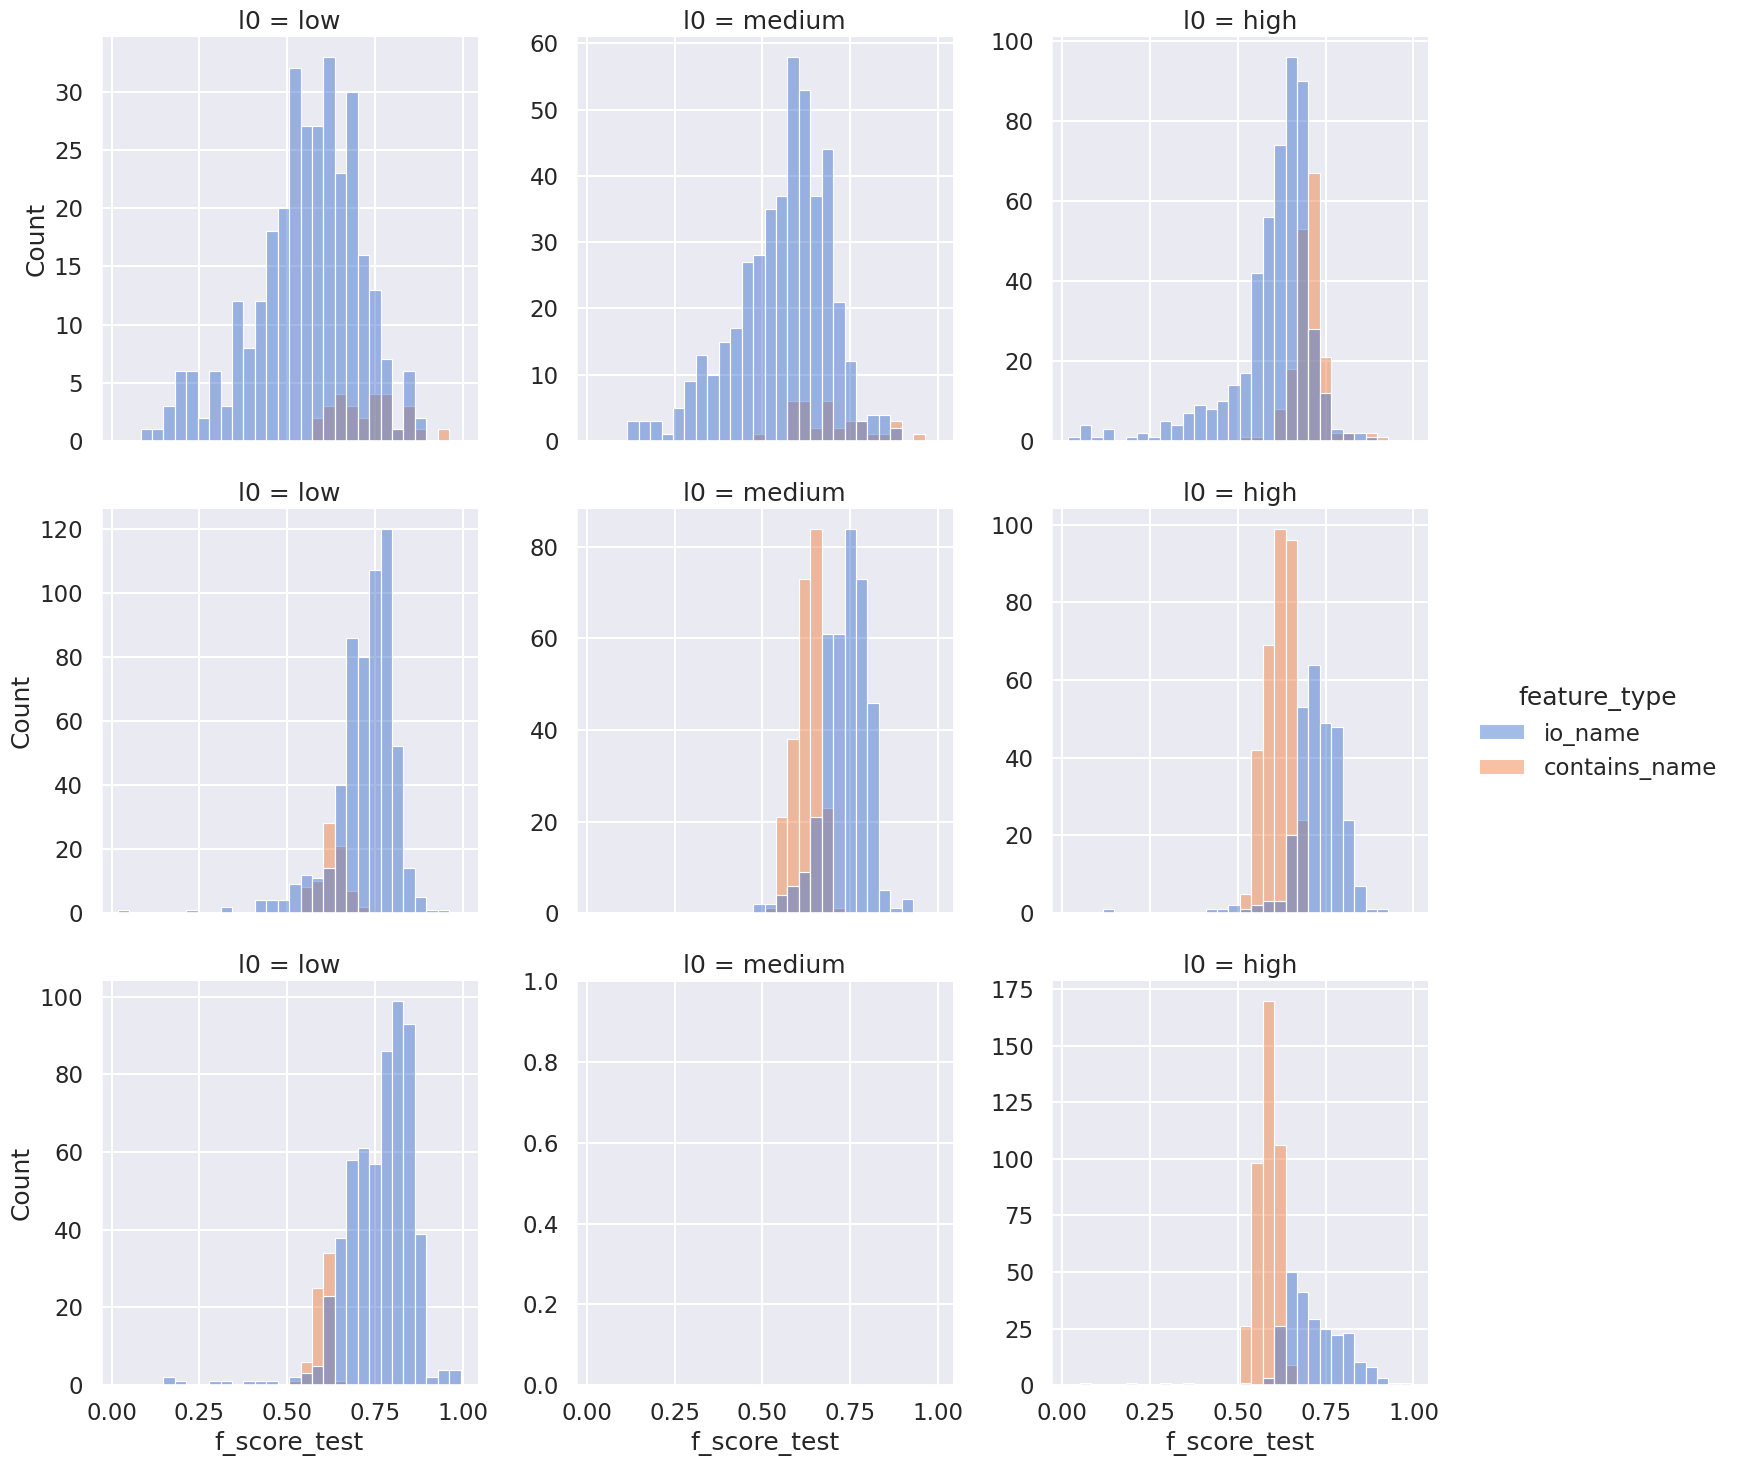

In [31]:
g = sns.displot(kind='hist', data=final_df[final_df.feature_type.isin(['io_name', 'contains_name']) & (final_df.f_score_test > 0.)], x='f_score_test', hue='feature_type', bins=30, col='l0', row='node', facet_kws={'sharex': True, 'sharey': False}, col_order=['low', 'medium', 'high'])
for ax in g.axes.flat:
    # Extract the 'l0' value from the original title
    # Original title format is expected to be "node = [node_value] | l0 = [l0_value]"
    # This will split the title on '|', strip extra whitespace, and keep only the part after 'l0 ='
    l0_value = ax.get_title().split('|')[-1].strip()
    # Set the new title with only the 'l0' value, adjusting the rotation as needed
    ax.set_title(l0_value, rotation=0)

# This implementation is nice and readable but fucking slow

Due to how pandas accesses multilevel index values. It's currently being fixed, e.g. https://github.com/pandas-dev/pandas/issues/38650

In [ ]:
import pandas as pd
import numpy as np

measure = pd.Categorical(['count', 'sum', 'total'], ordered=True)
pattern = pd.Categorical(['ABB', 'BAB'], ordered=True)
role = pd.Categorical(['s', 'io'])
multi_index = pd.MultiIndex.from_product([measure, pd.Categorical(ioi_nodes), pattern, role, pd.Categorical(NAMES), np.arange(saes[ioi_nodes[0]].cfg['d_hidden'])], names=['measure', 'node', 'pattern', 'role', 'name', 'neuron'])
df = pd.DataFrame(0, index=multi_index, columns=['data'])
df.info()
from tqdm import tqdm
from research.autoscoring import run_with_cache


for batch in tqdm(ioi_loader):
    cache = run_with_cache(model, batch, ioi_nodes)
    for i, node in enumerate(ioi_nodes):
        actvs = cache[i]  # (batch, neurons)
        feature_actvs = saes[node].encoder(actvs)
        is_active = feature_actvs > 0
        # this is slow because we can't batch it but the code is much more readable by using pandas
        for j, prompt in enumerate(batch.prompts):                
            df.loc[('count', node, prompt.pattern, 's', [prompt.s_name]), 'data'] += is_active[j].int().cpu().numpy()
            df.loc[('count', node, prompt.pattern, 'io', [prompt.io_name]), 'data'] += is_active[j].int().cpu().numpy()
            df.loc[('sum', node, prompt.pattern, 's', [prompt.s_name]), 'data'] += feature_actvs[j].cpu().numpy()
            df.loc[('sum', node, prompt.pattern, 'io', [prompt.io_name]), 'data'] += feature_actvs[j].cpu().numpy()
            df.loc[('total', node, prompt.pattern, 's', [prompt.s_name]), 'data'] += 1
            df.loc[('total', node, prompt.pattern, 'io', [prompt.io_name]), 'data'] += 1        
df[df.data>0]
# normalize the dataframe: divide sum by total and divide count by total, then remove total
df = df.unstack(level='measure')
df['sum'] = df[('data', 'count')] / df[('data', 'total')]
df['count'] = df[('data', 'count')] / df[('data', 'total')]
df = df.drop(columns='data')
df.head()
feature_types = pd.Categorical(['io_name', 's_name'], ordered=True)
feature_idx = np.arange(saes[ioi_nodes[0]].cfg['d_hidden'])
multi_index = pd.MultiIndex.from_product([pd.Categorical(ioi_nodes), feature_types, pd.Categorical(NAMES), feature_idx], names=['node', 'feature_type', 'name', 'feature_idx'])
feature_scores = pd.DataFrame(0, index=multi_index, columns=['score'])
feature_scores = feature_scores.sort_index(level=['node', 'feature_type', 'name', 'feature_idx'])
feature_scores
for node in ioi_nodes:
    for name in tqdm(NAMES):
        io_scores_abb = df.loc[(node, 'ABB', 'io', name, feature_idx), 'count'].to_numpy()
        io_scores_bab = df.loc[(node, 'BAB', 'io', name, feature_idx), 'count'].to_numpy()
        s_scores_aba = df.loc[(node, 'ABB', 's', name, feature_idx), 'count'].to_numpy()
        s_scores_baa = df.loc[(node, 'BAB', 's', name, feature_idx), 'count'].to_numpy()
        score = io_scores_bab * io_scores_abb - (s_scores_aba + s_scores_baa)
        feature_scores.loc[(node, 'io_name', name, feature_idx), 'score'] = score
        feature_scores.loc[(node, 's_name', name, feature_idx), 'score'] = s_scores_aba * s_scores_baa - (io_scores_bab + io_scores_abb)
feature_scores.to_csv('../data/feature_scores.csv')